In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('universal_tagset')
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Note: you may need to restart the kernel to use updated packages.


In [3]:
tags = ['NOUN', 'VERB', 'ADJ', 'ADV']


def tag_sentence(sentence):
    if type(sentence) == list:
        tokenized_sentence = sentence
    else:
        tokenized_sentence = word_tokenize(sentence)
    return pos_tag(tokenized_sentence, tagset='universal')

def label(sentence, tag):
    tagged_sentence = tag_sentence(sentence)
    return [*map(lambda x: 1 if tag == x[1] else 0, tagged_sentence)] 

def apply_ner(sentence):
    tagged_sentence = tag_sentence(sentence)
    ner_tagged_sentence = ne_chunk(tagged_sentence)
    return ner_tagged_sentence

sample_sentence = "The quick brown fox jumped over the red white something."
print(label(sample_sentence, tags[0]))
ner_result = apply_ner(sample_sentence)
print("NER Tags:", ner_result)

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
NER Tags: (S
  The/DET
  quick/ADJ
  brown/NOUN
  fox/NOUN
  jumped/VERB
  over/ADP
  the/DET
  red/ADJ
  white/ADJ
  something/NOUN
  ./.)


In [4]:
# Reading data
train_df = pd.read_json(path_or_buf=r'.\scicite\train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'.\scicite\test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'.\scicite\dev.jsonl', lines=True)

train_df = train_df[['string', 'label']]
test_df = test_df[['string', 'label']]
val_df = val_df[['string', 'label']]

train_df

,string,label
0,"However, how frataxin interacts with the Fe-S ...",background
1,"In the study by Hickey et al. (2012), spikes w...",background
2,"The drug also reduces catecholamine secretion,...",background
3,By clustering with lowly aggressive close kin ...,background
4,Ophthalmic symptoms are rare manifestations of...,background
...,...,...
8238,"Importantly, the results of Pascalis et al. (2...",background
8239,"As suggested by Nguena et al, there is a need ...",background
8240,Skeletal muscle is also a primary site of dise...,background
8241,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method


In [5]:
def correlation(vector1, vector2):
    vector1_array = np.array(vector1)
    vector2_array = np.array(vector2)
    
    mean1 = np.mean(vector1_array)
    mean2 = np.mean(vector2_array)

    covariance = np.mean((vector1_array - mean1) * (vector2_array - mean2))
    
    std1 = np.std(vector1_array)
    std2 = np.std(vector2_array)
    
    correlation_coefficient = covariance / (std1 * std2)
    
    return correlation_coefficient

In [6]:
import pickle

# Load the pickle file
with open('pred_attributions.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Display the loaded object
print(loaded_data)

{'background': [{'pred': 'method', 'label': 'background', 'input_ids': ['<s>', 'Ch', 'ap', 'el', ',', ' as', ' well', ' as', ' X', '10', ' [', '2', '],', ' U', 'PC', ' [', '3', ']', ',', ' Co', 'Array', ' Fort', 'ran', ' [', '6', '],', ' and', ' Titanium', ' [', '5', '],', ' rely', ' on', ' the', ' Part', 'ition', 'ed', ' Global', ' Address', ' Space', ' (', 'PG', 'AS', ')', ' memory', ' model', ',', ' which', ' enables', '\n', 'The', ' work', ' has', ' been', ' performed', ' under', ' the', ' H', 'PC', '-', 'E', 'UR', 'OPA', '2', ' project', ' (', 'project', ' number', ':', ' 228', '398', ')', ' with', ' the', ' support', ' of', ' the', ' European', ' Commission', ' -', ' Cap', 'ac', 'ities', ' Area', ' -', ' Research', ' Inf', 'rast', 'ruct', 'ures', '.', '</s>'], 'attributions': array([ 0.        ,  0.03409278,  0.00423927, -0.02617685, -0.09013799,
       -0.00675867,  0.01160856, -0.00838976,  0.01762242, -0.02748986,
        0.01337227, -0.00300767, -0.03365638, -0.00512438, -0.0

C:\Users\chris\AppData\Local\Temp\ipykernel_27196\3101612650.py:13: RuntimeWarning: invalid value encountered in scalar divide
  correlation_coefficient = covariance / (std1 * std2)


Mean: 0.1394269986396378
Median: 0.10762648704829961
Standard Deviation: 0.11492099372597249
Minimum: 0.0008287964689777379
Maximum: 0.6906517695483826


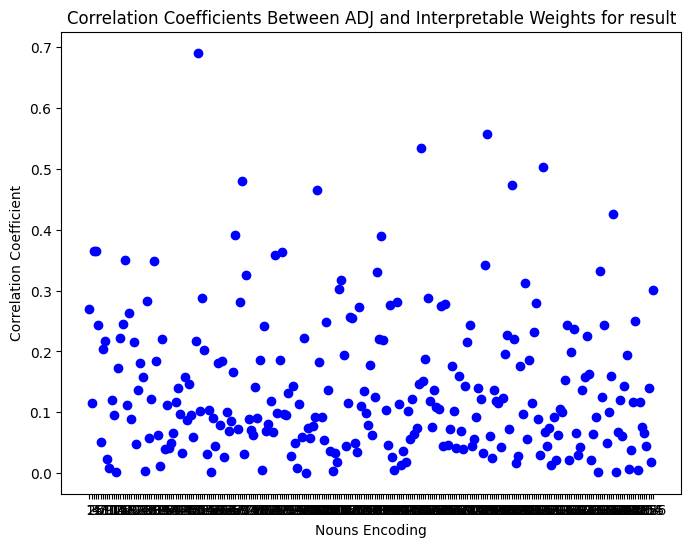

In [26]:
labels = ['background', 'method', 'result']
tags = ['NOUN', 'VERB', 'ADJ', 'ADV']

current_label = 2## 0 <= x <= 2
current_tag = 2 ## 0 <= x <= 3

def get_correlations(data, tag):
    correlation_coefficients = []
    
    for row in data:
        input_vector = label(row['input_ids'], tag)
        output_vector = row['attributions']
        corr = correlation(input_vector, output_vector)
        if -1 <= corr <= 1:
            correlation_coefficients.append(abs(corr))
    return correlation_coefficients

def visualize_correlation(correlation_coefficients, tag, label):
    x_values = range(1, len(correlation_coefficients) + 1)
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, correlation_coefficients, color='blue')
    
    plt.title(f'Correlation Coefficients Between {tags[tag]} and Interpretable Weights for {labels[label]}')
    plt.xlabel('Nouns Encoding')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(x_values)
    
    # Show plot
    plt.show()

def correlation_statistics(correlation_coefficients):
    coefficients_array = np.array(correlation_coefficients)
    mean = np.mean(coefficients_array)
    median = np.median(coefficients_array)
    std_deviation = np.std(coefficients_array)
    min_val = np.min(coefficients_array)
    max_val = np.max(coefficients_array)
    
    return {
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_deviation,
        'Minimum': min_val,
        'Maximum': max_val
    }

correlation_coefficients = get_correlations(loaded_data[labels[current_label]], tags[current_tag]) # change "background and tags for relevant changes"
stats = correlation_statistics(correlation_coefficients)


for stat, value in stats.items():
    print(f"{stat}: {value}")
visualize_correlation(correlation_coefficients, current_tag, current_label)